In [65]:
import numpy as np
# import torch
import random as rand
import matplotlib.pyplot as plt

In [66]:
def gen_count_sketch(m,n):
    hash=np.random.randint(100,1000)
    # hash=rand.randint(100,1000)
    # hash*i mod m
    omega = np.zeros((m,n))
    for i in range(n):
        pos = np.mod(hash*i,m)
        omega[pos,i]=1
    D = np.zeros((n,n))
    for i in range(n):
        D[i,i]=np.random.choice([-1,1])
    # print(omega)
    return omega @ D

In [67]:
def gen_composite_sketching_mat(s,R,epsilon):
    k1 = int(3*(R/epsilon))
    k2 = int(3*(R*R + R/epsilon))
    T = gen_count_sketch(s,k2)
    G= np.random.randn(k2,k1)*(1/np.sqrt(k1))
    S = T @ G
    # print(np.shape(T))
    # print(np.shape(G))
    return S


In [68]:
def Init_RRF(M,R,epsilon):
    m =np.shape(M)[1]
    S=gen_composite_sketching_mat(m,R,epsilon)
    B = M @ S
    U,sigma,V = np.linalg.svd(B)
    # print(np.shape(U))
    return U[:,:R]

In [69]:
"""
Input:  1) tensor: Input tensor
        2) n: mode along which to matricize the tensor (mode is 0-indexed)
Output: matrix: n-mode matricization of the tensor
"""
# Take mode = 0 for the first mode, mode = 1 for the second mode, ...., mode = n-1 for nth mode
def mode_n_matricization(tensor, n):
    mode = n
    # Get the size of the original tensor
    sz = tensor.shape
    # print(f"tensor size: {sz}")

    # Permute the dimensions of the tensor to bring the chosen mode to the front
    # This will make it easy to reshape the tensor into a matrix along the chosen mode
    permuted_dimensions = list(range(len(sz)))
#     print('Before Permuation, dimensions: ', permuted_dimensions)
    permuted_dimensions.remove(mode)
    permuted_dimensions.insert(0, mode)
#     print('After Permuation, dimensions: ', permuted_dimensions)
    permuted_tensor = tensor.transpose(*permuted_dimensions)
#     print(f"permuted tensor size: {permuted_tensor.size()}")

    # Reshape the permuted tensor into a matrix along the chosen mode
    matrix = permuted_tensor.reshape(sz[mode], -1)
#     print(f"matrix size: {matrix.size()}")

#     print(f"n-mode matricization along mode {mode}:")
#     print(matrix)

    return matrix

In [70]:
def RSVD_LRLS(Z, Y, R):

    m,s = Y.shape

    S = np.random.randn(s, 5*R)
    B = np.linalg.inv((Z.T @ Z))
    C= B @ Z.T @  Y @ S

    Q, r = np.linalg.qr(C)

    D = Q.T @ B @ Z.T @ Y

    U, sig , V = np.linalg.svd(D)

    sig = np.diag(sig)

    # print(U.shape)
    # print(sig.shape)
    # print(V.shape)
    return Q @ U[:, :R] @ sig[:R, :R] , V[:, :R]


In [71]:
# Testing RSVD-LRLS

m = 10
s = 5 
r = 8
R = 5

Z = np.random.randn(m, r)
Y = np.random.randn(m, s)

C , A = RSVD_LRLS(Z,Y,R)

print(C.shape)
print(A.shape)

(8, 5)
(5, 5)


In [72]:
def gen_tensor_sketch(m,sn):
    hash1 = np.random.randint(100,1000)
    hash2 = np.random.randint(100,1000)
    hash3 = np.random.randint(100,1000)
    hash4 = np.random.randint(100,1000)

    omega = np.zeros((m,sn))
    for i in range(sn):
        pos = np.mod(hash1 * (i **3) + hash2 * (i ** 2) + hash3 * (i) ,m)    # 3 wise independent hashes
        omega[pos,i]=1
    D = np.zeros((sn,sn))
    for i in range(sn):
        hash = np.mod(hash4 * (i **4) + hash1 * (i **3) + hash2 * (i ** 2) + hash3 * (i) ,2)   # 4 wise independent hashes
        D[i,i] = -1 if hash == 0 else 1
    return omega @ D

In [73]:
"""
Input: T: Input tensor
Output: equation: equation string for torch.einsum()
"""
def einsum_equation(T):
    equation = ''
    for i in range(len(T.shape)): 
        equation += f'{chr(97 + i)}'
    for i in range(len(T.shape)):
        equation += f',{chr(122 -i)}{chr(97 + i)}'
    equation += '->'
    for i in range(len(T.shape)):
        equation += f'{chr(122 - i)}'
    # print(f"equation: {equation}")
    return equation

T = np.random.randn(2,3,4,5,6)
eqn = einsum_equation(T)
print(f"equation: {eqn}")

equation: abcde,za,yb,xc,wd,ve->zyxwv


In [74]:
A = [None]
for n in range(1, 10):
    #T_tensor = torch.Tensor(T) 
    A.append(n)
print(A[9])

9


In [75]:
# # Testing Sketch Tucker
#  Error prone code since matrices are random
# tensor = np.random.randn(10,10,10)
# ranks = (5,5,5)
# imax = 5
# eps = 0.1

# Sketch_Tucker_ALS(tensor, ranks, imax, eps)

In [76]:
"""
Input: A: Array of matrices whose Khatri-Rao product is to be calculated
Output: B: Khatri-Rao product of the matrices in A
"""
def khatri_rao_product(A):
    N = len(A)
    num_cols = A[0].shape[1]
    x_dim = 1
    for i in range(N):
        x_dim *= A[i].shape[0]
    B = np.empty((x_dim, num_cols))

    for i in range(num_cols):
        for j in range(N):
            if j == 0:
                kron_prod = A[j][:, i]
            else:
                kron_prod = np.kron(kron_prod, A[j][:, i])
        B[:, i] = kron_prod

    return B

In [77]:
"""
Input:  1) T: Tensor of size (s_1, s_2, ..., s_N)
        2) R: CP-Rank of the Tensor
Output: 1) A: Array of N factor matrices of size (s_i, R)
"""
def CP_ALS(T, R, max_iter=100, tol=1e-5):
    N = len(T.shape)
    sz = T.shape
    A = []
    for n in range(N):
        An = np.random.rand(sz[n], R)
        A.append(An)

    # Iterate until convergence
    for iter in range(max_iter):
        prev_factors = A.copy()

        for n in range(N):
            # Calculate the Khatri-Rao product of all the factor matrices except the n-th factor matrix
            B = khatri_rao_product(A[:n] + A[n+1:])
            B_pinv = np.linalg.pinv(B)

            # Calculate the n-mode matricization of the tensor
            Tn = mode_n_matricization(T, n)
            
            # Calculate the n-th factor matrix
            AnT = np.matmul(B_pinv, Tn.T)
            A[n] = AnT.T

        # Check for convergence
        if all(np.linalg.norm(A[i] - prev_factors[i]) < tol for i in range(T.ndim)):
            print(f"Converged at iteration {iter}")
            break

    return A  
    

In [78]:
def Sketch_Tucker_ALS(T, ranks, Imax=10, epsilon=0.1):

    N = len(ranks)
    C = np.zeros(ranks)

    A = []
    for n in range(N):
        #T_tensor = torch.Tensor(T) 
        A.append(Init_RRF(mode_n_matricization(T, n), ranks[n], epsilon))

    fitness_arr = []
    
    for i in range(Imax):
        fitness = 0
        for n in range(N):
            # Build sketching S
            shape = T.shape
            shp = 1
            for s in range(len(shape)):
                if s != n :
                    shp = shp * shape[s]

            #Computing A_kronecker
            if n == 0:
                A_kronecker = A[1]
                for j in range(2, N):
                    A_kronecker = np.kron(A_kronecker, A[j])
            else:
                A_kronecker = A[0]
                for j in range(1, N):
                    if j != n:
                        A_kronecker = np.kron(A_kronecker, A[j])

            Sn = gen_tensor_sketch(m, shp)
            Y = Sn @ (mode_n_matricization(T, n)).T
            Z = Sn @ A_kronecker

            while np.linalg.det((Z.T@Z))==0:
                Sn = gen_tensor_sketch(m, shp)
                Y = Sn @ (mode_n_matricization(T, n)).T
                Z = Sn @ A_kronecker

            #print(f'n = {n} and Sn = {Sn.shape}')
            #print(f'n = {n} and Akron = {A_kronecker.shape}')

            # print("Sizes of A[i]: ")
            # for k in A:
                # print(k.shape)
            C_matrix, A[n] = RSVD_LRLS(Z, Y, ranks[n]) 

            C = mode_n_matricization(C, n)
            C = C_matrix.T
            C = C.reshape(ranks)
            
            eqn = einsum_equation(T)
            #print(type(T), type(A_T))
            A_T = [A[i].T for i in range(N)]
            C = np.einsum(eqn,T,*A_T)

            fitness = 1 - np.linalg.norm(T - np.einsum(eqn,C,*A))/np.linalg.norm(T)
        fitness_arr.append(fitness)
    return (C, A, fitness_arr)


In [79]:
def CP_Sketch_Tucker(T, R, Imax, epsilon):

    N = T.ndim
    ranks = tuple([R] * N)
    C, B = Sketch_Tucker_ALS(T, ranks, Imax, epsilon)
    A = CP_ALS(C, R)
    result = []

    for i in range(len(A)):
        result.append(B[i] @ A[i])

    return result


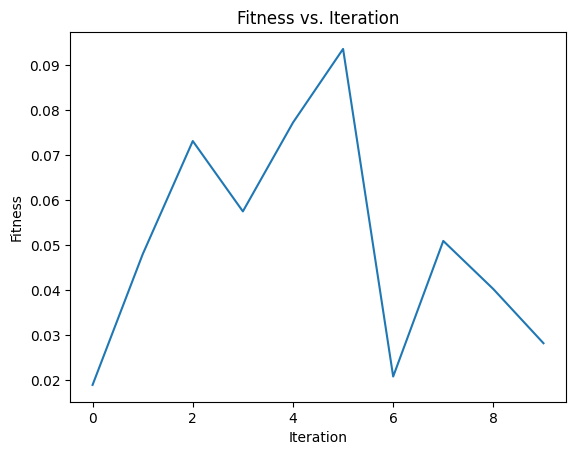

In [80]:
#Now plot

tensor = np.random.randn(2,4,3,5)
ranks = (1,3,2,2)
C, A, fitness_arr = Sketch_Tucker_ALS(tensor, ranks)
itera=[i for i in range(len(fitness_arr))]
plt.plot(itera, fitness_arr)
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.title('Fitness vs. Iteration')
plt.show()
